# Heat Conduction

**Intputs**

- `qprime`: Linear heat generation rate ($\frac{W}{m}$)
- `mdot`: Mass flow rate ($\frac{g}{s}$)
- `Tin`: Temperature of the fuel boundary ($K$)
- `R`: Fuel radius ($m$)
- `L`: Fuel length ($m$)
- `Cp`: Heat capacity ($\frac{J}{g \cdot K}$)
- `k`: Thermal conductivity ($\frac{W}{m \cdot K}$)

**Output**

- `T`: Fuel centerline temperature ($K$)

This data set consists of 1000 data points with 7 inputs and 1 output. The data set was constructed through Latin hypercube sampling of the 7 input parameters for heat conduction through a fuel rod. These samples were then used to solve for the fuel centerline temperature analytically. The geometry of the problem is illustrated in the figure below, and it is assumed volumetric heat generation is uniform radially. The problem is defined by

\begin{equation}
\frac{1}{r}\frac{d}{dr}(kr\frac{dT}{dr}) + q''' = 0,
\end{equation}

with two boundary conditions: $\frac{dT}{dr}|_{r = 0} = 0$ and $T(R) = T_{in}$. Therefore, the temperature profile in the fuel is

\begin{equation}
T(r) = \frac{q'}{4\pi k}(1 - (r / R)^2) + T_{in}.
\end{equation}

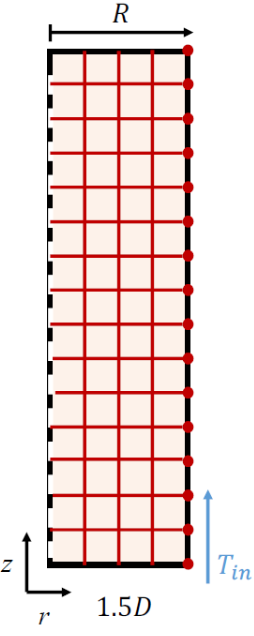

The following are a few common packages and functions that will prove useful while using pyMAISE along with pyMAISE specific functionality. 

In [24]:
# Importing Packages
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
import pyMAISE as mai
from pyMAISE.datasets import load_heat
from pyMAISE.preprocessing import scale_data, train_test_split, correlation_matrix

## pyMAISE Initialization

We first start by initializing pyMAISE settings and then import the data set using `load_heat()` from the pyMAISE dataset library.

In [25]:
# Settings 
settings = {
    "verbosity": 0,
    "random_state": 42,
    "test_size": 0.3,
    "num_configs_saved": 5,
    "cuda_visible_devices": "-1", # Use CPUs only
}

# Problem type for a regression, problem = 0
problem_type = mai.ProblemType(0)

# Initializing pyMaise settings
global_settings = mai.settings.init(problem_type=mai.ProblemType.REGRESSION, settings_changes=settings)

# Get data from repoisitory
data, inputs, outputs = load_heat()

The heat conduction data set has 7 inputs

In [26]:
inputs

<xarray.DataArray (index: 1000, variable: 7)>
array([[3.59879928e+04, 2.06185816e+02, 5.73151869e+02, ...,
        3.44815496e+00, 4.09614034e+00, 9.60945479e-01],
       [3.84810558e+04, 1.92378974e+02, 5.73150960e+02, ...,
        3.43683275e+00, 4.24918181e+00, 1.01127217e+00],
       [3.91432921e+04, 2.05076928e+02, 5.73153975e+02, ...,
        3.68145722e+00, 4.23754044e+00, 9.94646131e-01],
       ...,
       [4.01365078e+04, 1.91977771e+02, 5.73151522e+02, ...,
        3.63435094e+00, 4.12297685e+00, 1.01905766e+00],
       [4.06288682e+04, 1.93001960e+02, 5.73152035e+02, ...,
        3.64753610e+00, 4.21262950e+00, 9.68979168e-01],
       [3.90566005e+04, 1.87235532e+02, 5.73153905e+02, ...,
        3.40448532e+00, 4.06543435e+00, 1.00688469e+00]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'qprime' 'mdot' 'Tin' 'R' 'L' 'Cp' 'k'

and 1 output with 1000 data points.

In [27]:
outputs

<xarray.DataArray (index: 1000, variable: 1)>
array([[1034.13378385],
       [1170.31604229],
       [1164.89356528],
       [1205.25003976],
       [1444.71866607],
       [1415.16087218],
       [1141.02596298],
       [1135.41902917],
       [1087.37893848],
       [1484.62104894],
       [1095.53986907],
       [1173.29114652],
       [1157.14848053],
       [1256.81754162],
       [1118.14237521],
       [1042.34706612],
       [1049.5434326 ],
       [1181.84317152],
       [1425.17119154],
       [1201.11399329],
...
       [1440.68291936],
       [1126.62859092],
       [1118.47511015],
       [1215.64386477],
       [1506.41447337],
       [1118.13383746],
       [1427.1010686 ],
       [1070.54469832],
       [1393.14664198],
       [1374.22902546],
       [1142.38817778],
       [1487.82931858],
       [1103.84446468],
       [1161.70719007],
       [1503.51884631],
       [1396.11284268],
       [1570.4571551 ],
       [1438.29381922],
       [1374.74521282],
       [1187.64399672]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * variable  (variable) object 'T'

To better understand the data here is a correlation matrix of the data.

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

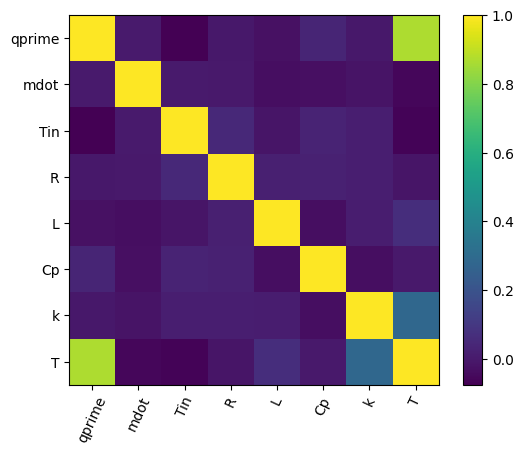

In [28]:
correlation_matrix(data)

As expected there is a strong correlation between linear heat generation rate, `qprime`, and the centerline fuel temperature, `T`.

Prior to model training the data is split into training/test along with min-max scaling to make each feature's effect size comperable. Additionaly, this can improve the performance of some models.

In [29]:
# Train test split data
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.30)

# Min-Max scaling data 
xtrain, xtest, _ = scale_data(xtrain, xtest, MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, MinMaxScaler())
data = (xtrain, xtest, ytrain, ytest)

## Model Initialization

We will examine the performance of 6 models in this data set:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyper-parameter tuning each model we must be initialized the architecture and optimization search spaces.

In [30]:
# Initializing all the models wanted in the model)settings variable along with neurel network archetecture/optimization hps
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=400),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=3),
                "units": mai.Int(min_value=25, max_value=300),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32, 64]),
            "epochs": 100,
            "validation_split": 0.15,
        },
    },
}
# Constructing Tuner object for the search space above
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

While three hyper-parameter tuning functions are supported (`grid_search`, `random_search`, and `bayesian_search`), `random_search` and `bayesian_search` are used for the classical ML and `nn` models, respectively. `random_search` randomly samples a defined parameter space and the number of models generated is easily defined. A large number of classical models are generated through `random_search` as they are relatively quick to train. However, the prohibative time required to train neural networks makes `bayesian_search` more appealing as the search converges to the optimal hyper-parameters in relatively few iterations. The hyper-parameter search spaces are outlined below, many with Scipy uniform distributions. Cross validation is used in both search methods to eliminate bias from the data set.

In [31]:
# Classical Model search space
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "svr": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

# Running the tuner for with the search algorithm desired
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=300, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=100,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 100 Complete [00h 00m 29s]
r2_score: 0.44289405571587875

Best r2_score So Far: 0.9735782389333991
Total elapsed time: 01h 01m 12s
Hyperparameter tuning took 61.193900219599406 minutes to process.


With the conclusion of hyper-parameter tuning we can see the training results of each iteration of the bayesian search.

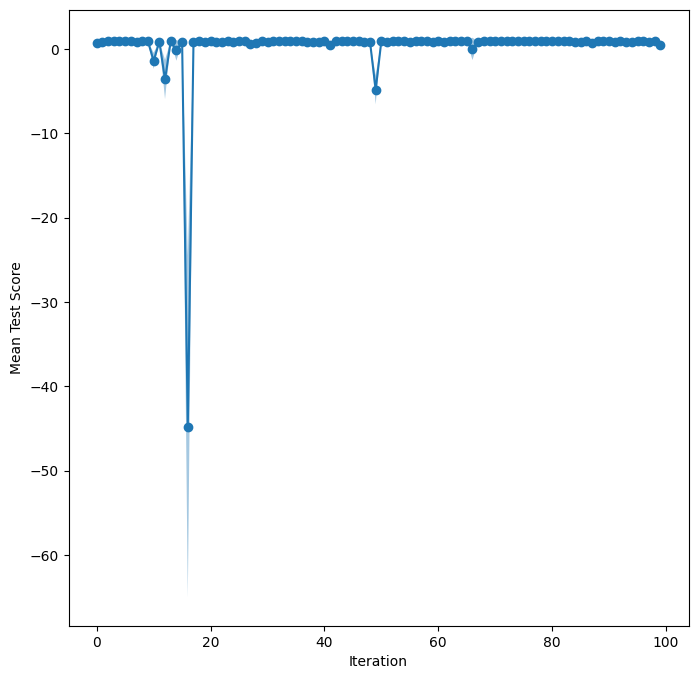

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuner.convergence_plot(model_types="FNN")

After about 19 iterations the bayesian search converges on the optimal solution for this parameter space.

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `epochs` of the `nn` models for better performance.

In [33]:
new_model_settings = {
    "FNN": {
        "fitting_params":{
            "epochs": 200,
        }
    }
}
postprocessor = mai.PostProcessor(
    data=data,
    model_configs=[random_search_configs, bayesian_search_configs],
    new_model_settings=new_model_settings,
    yscaler=yscaler,
)

To compare the performance of these models, we will compute 4 metrics for both the training and testing data: 

In [34]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
3,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.998859,3.333228,26.357340,5.133940,0.989197,10.182648,251.207192,15.849517
2,DT,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",1.000000,0.000000,0.000000,0.000000,0.982872,14.740708,398.300473,19.957467
9,FNN,"{'Dense_input_0_units': 111, 'Dense_input_0_su...",0.990224,7.092137,225.880145,15.029310,0.975602,10.843580,567.355261,23.819220
6,FNN,"{'Dense_input_0_units': 50, 'Dense_input_0_sub...",0.986933,5.789058,301.904702,17.375405,0.971081,8.113459,672.469614,25.932019
5,FNN,"{'Dense_input_0_units': 346, 'Dense_input_0_su...",0.973643,7.010574,608.967669,24.677270,0.968864,7.018587,724.039369,26.907980
7,FNN,"{'Dense_input_0_units': 311, 'Dense_input_0_su...",0.966402,10.712575,776.254434,27.861343,0.964938,10.838150,815.323242,28.553866
8,FNN,"{'Dense_input_0_units': 355, 'Dense_input_0_su...",0.987116,4.131909,297.671063,17.253146,0.957695,7.895282,983.767118,31.365062
0,Linear,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.846581,51.308561,3544.662697,59.537070,0.835141,53.454015,3833.607529,61.916133
4,KN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.859634,41.863853,3243.089812,56.948133,0.772636,56.272461,5287.093251,72.712401
1,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.000000,142.176198,23104.451208,152.001484,-0.037210,144.106395,24119.176946,155.303499


As this data set represents radial heat conduction, we do not expect linear models to perform well. This is shown by the relatively poor performance of `linear` and `lasso`. The best perfroming models were `rforest` and `dtree` with test and train r-squared above 0.99. 

Using the `get_params` function we can see the optimal hyper-parameter configurations for each model.

In [35]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 1.0
copy_X: True
fit_intercept: True
max_iter: 1000
normalize: deprecated
positive: False
precompute: False
random_state: None
selection: cyclic
tol: 0.0001
warm_start: False

Model Types: DT
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: None
splitter: best

Model Types: RF
bootstrap: True
ccp_alpha: 0.0
criterion: squared_error
max_depth: None
max_features: 1.0
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False

Model Types: KN
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform

Model Types: FNN
Dense_input_0_units: 111
Dense_input_0_sublayer: None
Dense_i

To visualize the performance of these models we can use the `diagonal_validation_plot` functions to produce diagonal validation plots.

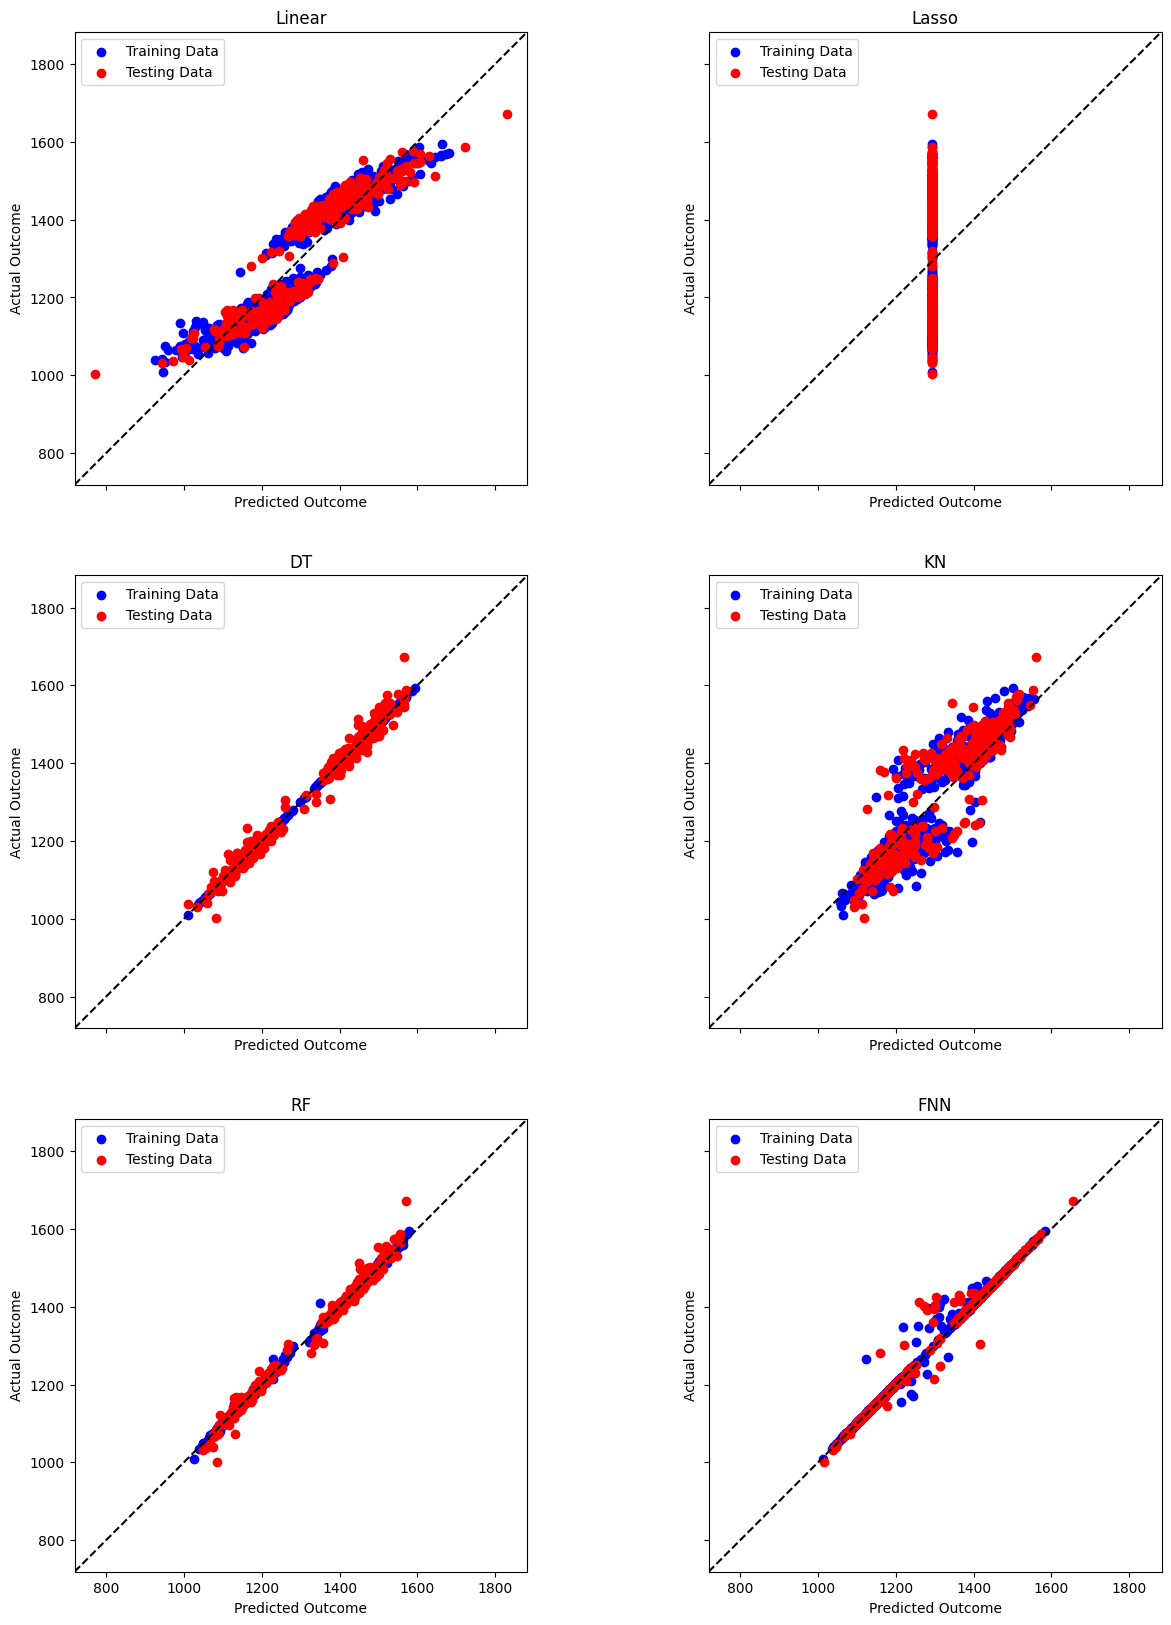

In [36]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
fig, axarr = plt.subplots(models.shape[0], models.shape[1], sharex=True, sharey=True, figsize=(15,20))
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])

The performance differences between `RF`/`DT` with the other models is apparent along with the overfitting of `KN`. The FN was also slightly overfit for the best performing r-squared scores. The predictions of `RF` and `DT` are closely spread along $y=x$ while the `KN` test predictions are over-predicted at lower temperatures and under-predicted at higher temperatures.

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each prediction.

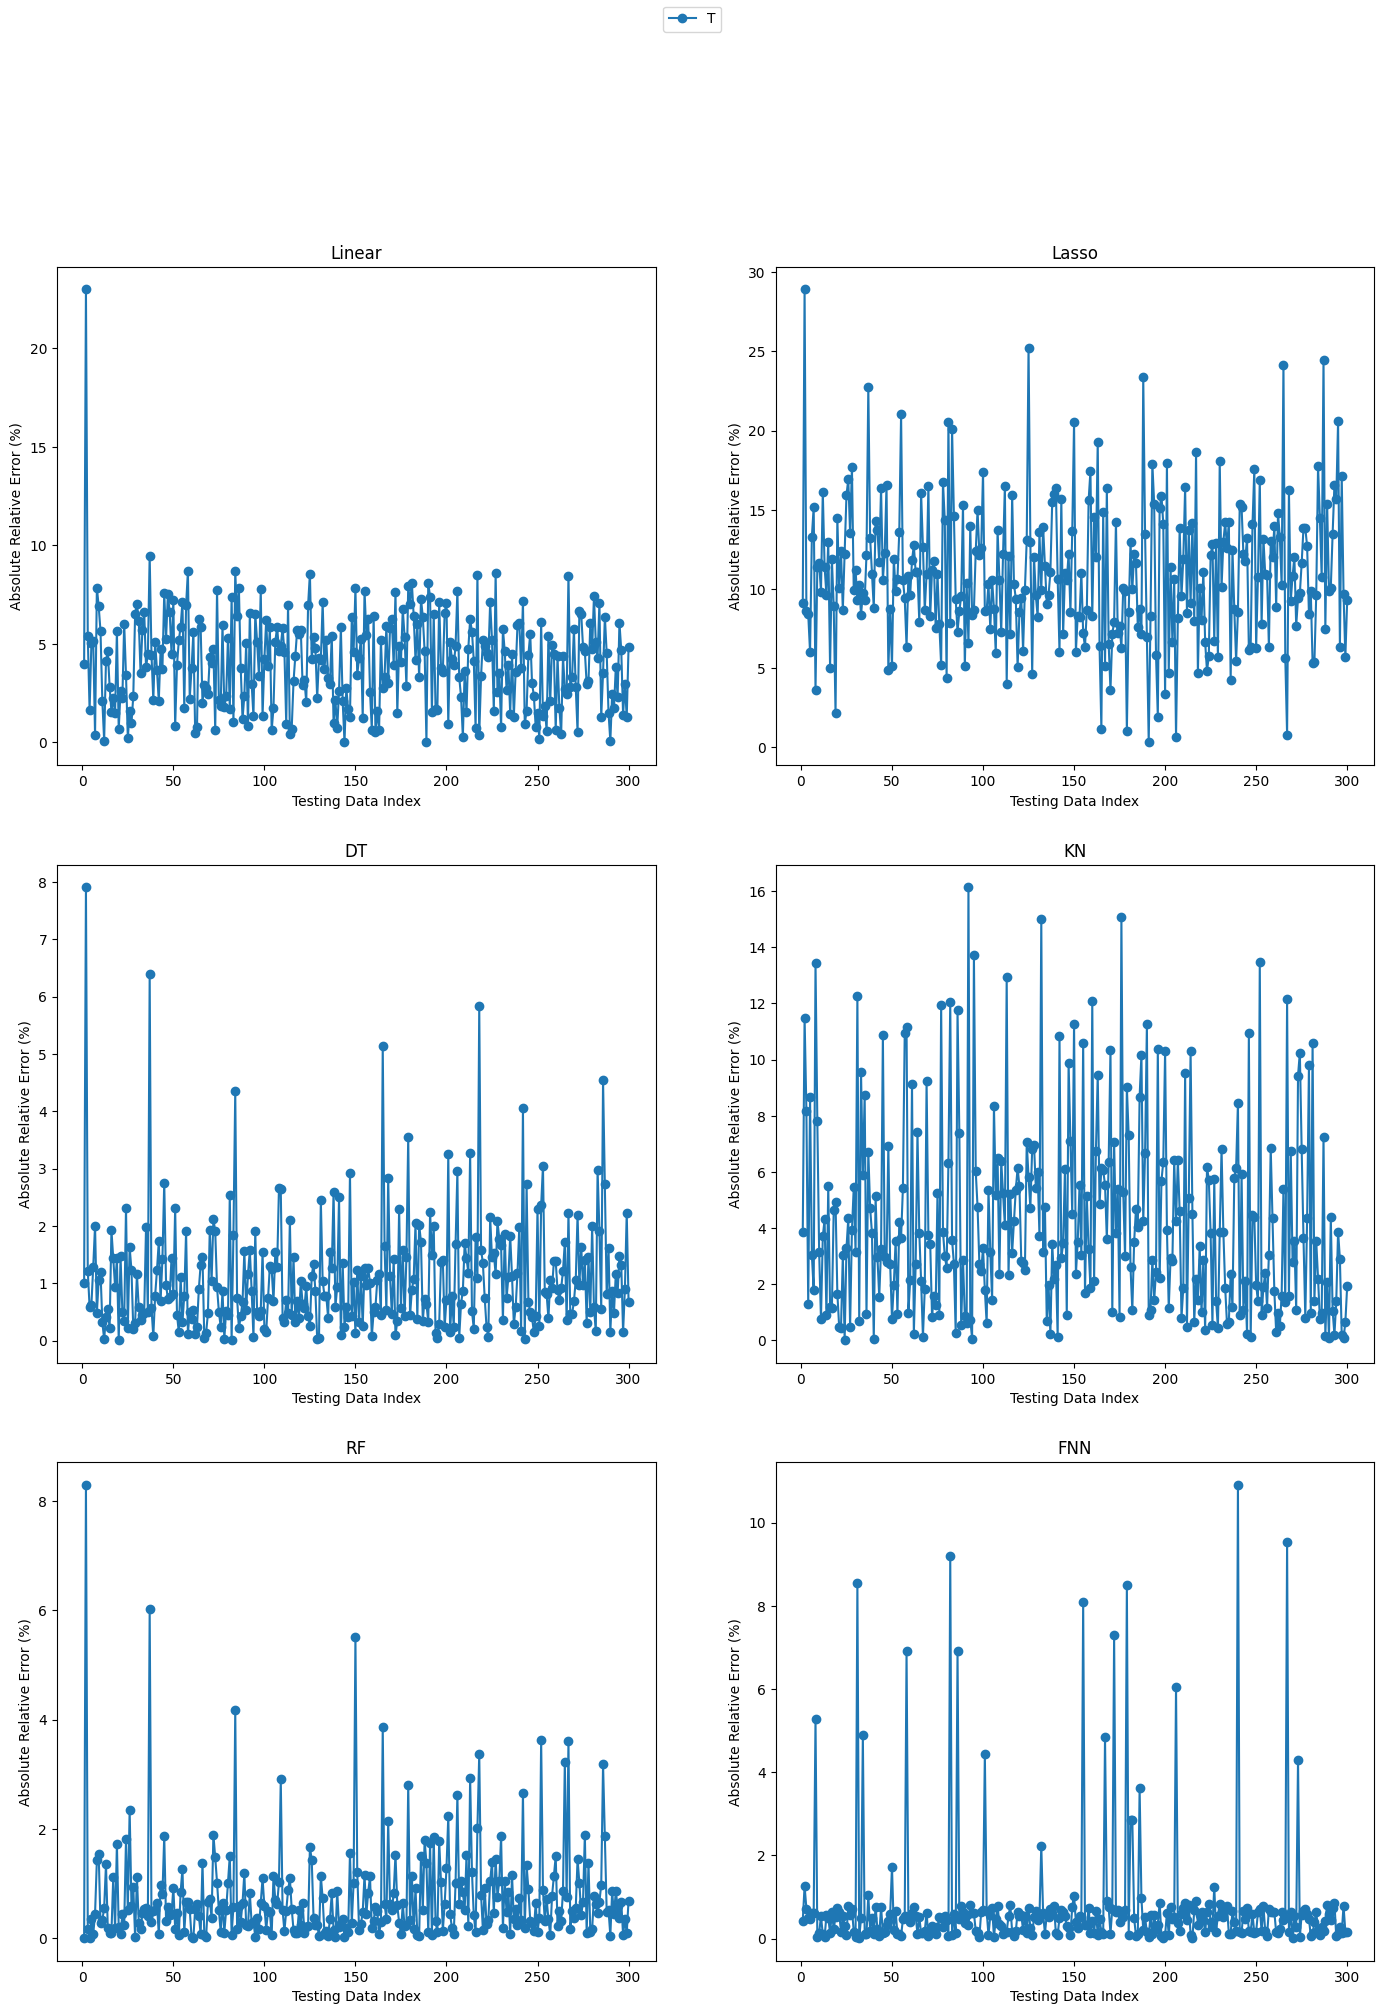

In [41]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["T"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend()

fig.legend(y, loc="upper center", ncol=4)

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `rforest` gets as high as $>9.0\%$ error. 

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

In [42]:
postprocessor.nn_learning_plot()

AssertionError: 

The validation curve is below the training curve; therefore, the `nn` is not overfit. 

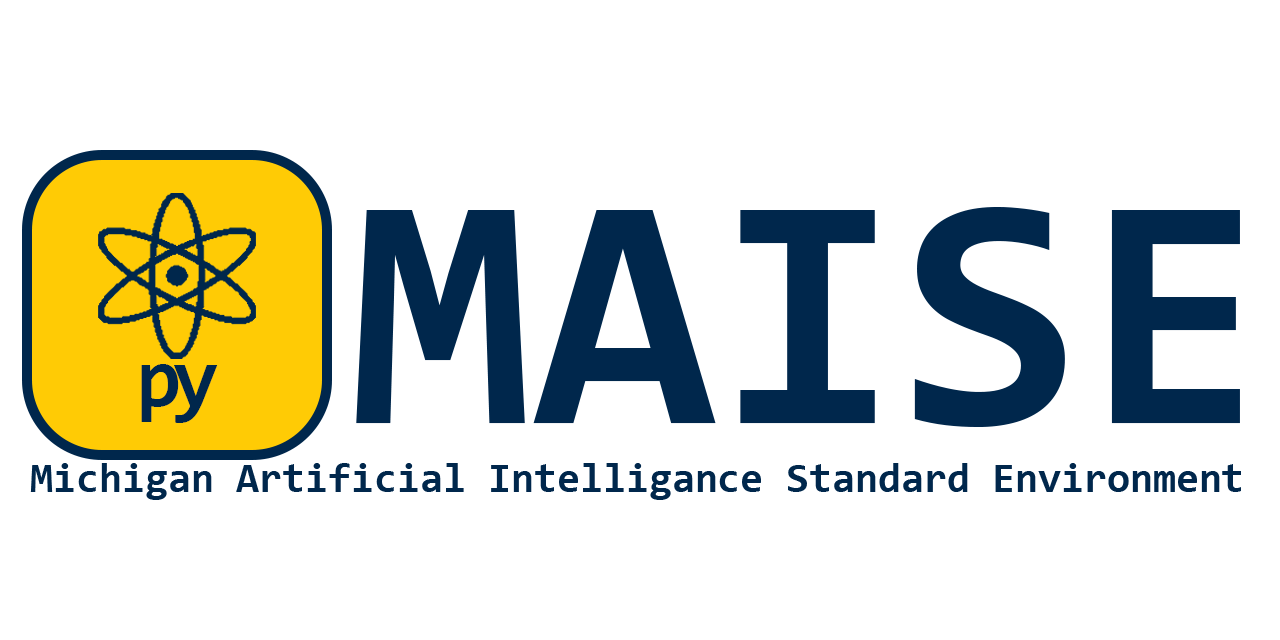